# **ЗАДАНИЕ 7. ПОСТРОЕНИЕ МОДЕЛИ АВТОРЕГРЕССИИ**
Рассчитайте коэффициенты автокорреляции для временного ряда цен на материал 3. На их основе определите порядок авторегрессии и постройте соответствующую модель. Рассчитайте показатели точности и адекватности построенной модели. Дайте точечный и интервальный прогнозы на 1 год вперёд по построенной модели.
Постарайтесь максимально автоматизировать все вычисления, использовать существующие модули среды программирования Python.


In [ ]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 6.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import scipy.stats
from sklearn.linear_model import LinearRegression

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**1.	Прочитайте данные по ценам на материал 3 и приведите их к виду, пригодному для дальнейшего анализа (см. пп.1-10 Задания 1).**

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/DOM/')

In [ ]:
data=pd.read_csv('Month_Value_1.csv')
data.tail(40)

In [ ]:
data.Revenue.isna().sum()

In [ ]:
df = data.iloc[:60,:2]
df['Period'] = pd.to_datetime(df.Period)

In [ ]:
df = df.set_index('Period')

In [ ]:
df.Revenue = df.Revenue.astype('int')

In [ ]:
df.dtypes

Revenue    int64
dtype: object

In [ ]:
series = df.squeeze()
series[48:]

**3.	Посмотрите на динамику временного ряда с помощью функций plot() и show() из модуля matplotlib.pyplot. Прокомментируйте результат.**

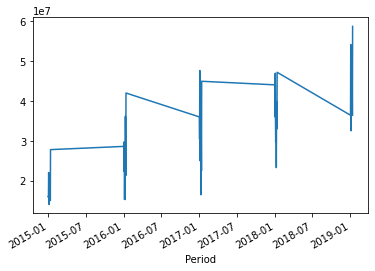

In [ ]:
series.plot()
plt.show()

**4.	Рассчитайте максимальную величину лага (max_tau), как 4-ую часть объема выборки. Выведите результат на экран.**

In [ ]:
max_tau=int(len(series)/5)
max_tau

12

**5.	По ряду цен постройте коррелограмму. Воспользуйтесь функцией autocorrelation_plot() из модуля pandas.plotting.**

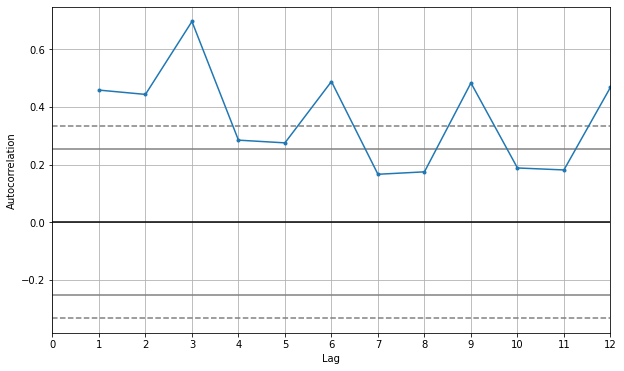

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

autocorrelation_plot(series, ax = ax, marker = '.')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlim(0, max_tau)

plt.show()

**6.	Для всех значений лага от 1 до max_tau и коэффициентов автокорреляции, вычисленных с помощью функции autocorr(lag=i), по модулю больших 0,8, выведите на экран лаг и значение коэффициента автокорреляции.**

In [ ]:
for i in range(1,max_tau+1):
  if series.autocorr(lag=i)>=0.8 or series.autocorr(lag=i)<=-0.8:
    print('tau=',i, 'r=',series.autocorr(lag=i))

tau= 12 r= 0.8467130205407912


**7.	Постройте таблицу данных на основе значений цены на материал 3, воспользовавшись функцией DataFrame() из модуля pandas, результат поместите в переменную values.**

In [ ]:
values=pd.DataFrame(series.values)

**8.	Поместите в переменную dataframe исходный ряд и сдвинутый на x шагов, где x соответствует лагам из п. 6, воспользовавшись функцией concat([values.shift(x), values], axis=1) из модуля pandas.**

In [ ]:
dataframe =pd.concat([values.shift(6),values.shift(5),values.shift(4),values.shift(3),values.shift(2),values.shift(1), values], axis=1)

**9.	Дайте полученным столбцам названия 't' и 't-x', воспользовавшись следующей командой: df.columns = [ 't-x', 't']. Выведите на экран первые 10 значений, воспользовавшись функцией head().**

In [ ]:
dataframe.columns = [ 't-6','t-5','t-4','t-3','t-2','t-1', 't']

In [ ]:
dataframe.head(10)

,t-6,t-5,t-4,t-3,t-2,t-1,t
0,NaN,NaN,NaN,NaN,NaN,NaN,16010072
1,NaN,NaN,NaN,NaN,NaN,16010072.0,15807587
2,NaN,NaN,NaN,NaN,16010072.0,15807587.0,22047146
3,NaN,NaN,NaN,16010072.0,15807587.0,22047146.0,18814583
4,NaN,NaN,16010072.0,15807587.0,22047146.0,18814583.0,14021479
5,NaN,16010072.0,15807587.0,22047146.0,18814583.0,14021479.0,16783928
6,16010072.0,15807587.0,22047146.0,18814583.0,14021479.0,16783928.0,19161892
7,15807587.0,22047146.0,18814583.0,14021479.0,16783928.0,19161892.0,15204984
8,22047146.0,18814583.0,14021479.0,16783928.0,19161892.0,15204984.0,20603939
9,18814583.0,14021479.0,16783928.0,19161892.0,15204984.0,20603939.0,20992874


**10.	Создайте переменную array, в которую запишите значения переменных таблицы dataframe, обратившись к параметру values.**

In [ ]:
array=dataframe.values

**11.	Разделите исходные данные на тестовый набор (12 последних наблюдений) и обучающий набор (оставшиеся наблюдения). Для этого создайте переменные x_train и y_train, содержащие данные обучающей выборки и переменные x_test и y_test с данными тестовой выборки. Выведите на экран объем обучающей и тестовой выборки.**

In [ ]:
x_train =array[6:36,0:6]
y_train=array[6:36,6]
x_test =array[36:48,0:6]
y_test =array[36:48,6]

**12.	Создайте модель линейной регрессии, воспользовавшись функцией LinearRegression() из модуля sklearn.linear_model. Обучите на обучающей выборке модель линейной регрессии, воспользовавшись функцией fit(). Результат запишите в переменную model.**

In [ ]:
model=LinearRegression().fit(x_train,y_train)

**13.	Выведите на экран свободный член модели линейной регрессии, обратившись к ее параметру intercept_.**

In [ ]:
model.intercept_

-1.1305838135582906

**14.	Выведите на экран коэффициенты при независимых переменных в модели линейной регрессии, обратившись к ее параметру coef_.**

In [ ]:
model.coef_

array([ 0.28957294,  0.30568777, -0.33216294, -0.06657351,  0.67201834,
        0.24478978])

**15.	Найдите расчетные значения результативного признака по модели линейной регрессии на тестовом наборе и запишите их в переменную y_pred. Выведите на экран полученный результат.**

In [ ]:
y_pred=model.predict(x_test)
y_pred

array([10.16431481, 10.15690398, 10.1665792 , 10.18303598, 10.20013965,
       10.19035092, 10.16939356, 10.17927216, 10.17867211, 10.17488271,
       10.15879661, 10.15708596])

**16.	Оцените точность модели на тестовой выборке на основе средней квадратичной ошибки (MSE), воспользовавшись функцией mean_squared_error(y_test, y_pred) из модуля sklearn.metrics. Запишите результат.**

In [ ]:
MSE=mean_squared_error(y_test, y_pred)
MSE

0.0008264392588580527

In [ ]:
r2_score(y_test, y_pred)

-1.271130787701499

# **СТРОИМ МОДЕЛЬ НА ВСЕХ ДАННЫХ**

**19.	Постройте на всех данных лучшую модель.**

In [ ]:
x=array[6:48,0:6]
y=array[6:48,6]

In [ ]:
model=LinearRegression().fit(x,y)

In [ ]:
model.intercept_

0.5453373690949501

In [ ]:
model.coef_

array([ 0.07860707,  0.25185438, -0.24411278, -0.1826131 ,  0.68145948,
        0.36131217])

In [ ]:
y_pred=model.predict(x)

**20.	Оцените точность модели для всех данных с помощью следующих показателей: коэффициента детерминации, MAE, MSE, RMSE. Соответствующие функции приведены в задании 4. Прокомментируйте полученные результаты.**

In [ ]:
R2=r2_score(y,y_pred)
R2

0.8794182876013034

In [ ]:
MAE=mean_absolute_error(y,y_pred)
MAE

0.015211336689007584

In [ ]:
MSE=mean_squared_error(y,y_pred)
MSE

0.00030772261604604015

In [ ]:
RMSE=sqrt(MSE)
RMSE

0.017542024285869637

In [ ]:
len(y_pred)

42

In [ ]:
y=df.Value[6:48]

**21.	Рассчитайте ошибки модели для всех данных. Поместите столбец ошибок 'Error' в таблицу исходных данных. Выведите на экран первые 5 наблюдений.**

In [ ]:
df['Error']=y-y_pred
df.head(10)

,Value,Error
Date,,
2007-01-01,10.07,NaN
2007-02-01,10.04,NaN
2007-03-01,10.05,NaN
2007-04-01,10.05,NaN
2007-05-01,10.03,NaN
2007-06-01,10.03,NaN
2007-07-01,10.06,0.024067
2007-08-01,10.03,-0.020585
2007-09-01,10.05,-0.015858


In [ ]:
err=df['Error'][6:48]
err.head()

Date
2007-07-01    0.024067
2007-08-01   -0.020585
2007-09-01   -0.015858
2007-10-01   -0.002125
2007-11-01   -0.028724
Name: Error, dtype: float64

**22.	Постройте линейный график ошибок, воспользовавшись функцией plot() и командой pyplot.show() из модуля matplotlib. Прокомментируйте результат.**

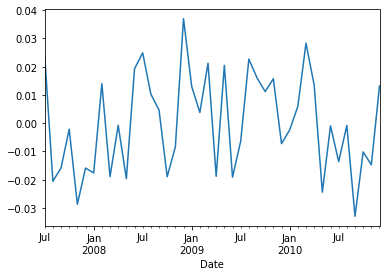

In [ ]:
err.plot()
plt.show()

**23.	Выведите на экран описательные статистики ошибок, воспользовавшись функцией describe(). Прокомментируйте результат.**

In [ ]:
err.describe()

count    4.200000e+01
mean     5.075305e-16
std      1.775466e-02
min     -3.300461e-02
25%     -1.589665e-02
50%     -8.859810e-04
75%      1.386714e-02
max      3.702900e-02
Name: Error, dtype: float64

**24.	Постройте для ошибок гистограмму на основе функции hist(), ядерную оценку плотности на основе функции plot(kind='kde'), Q-Q график на основе функции qqplot() из модуля statsmodels.graphics.gofplots, а также функцией show() из matplotlib.pyplot. Прокомментируйте результат.**

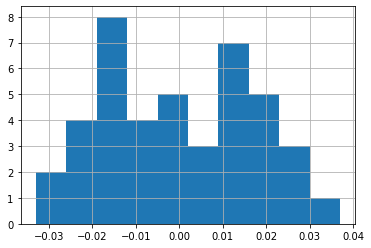

In [ ]:
err.hist()
plt.show()

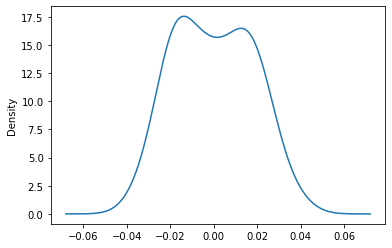

In [ ]:
err.plot(kind='kde')
plt.show()

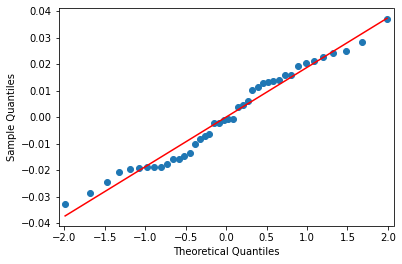

In [ ]:
qqplot(err,line='r')
plt.show()

**25.	Постройте для ошибок коррелограмму, воспользовавшись функцией autocorrelation_plot() из модуля pandas.plotting. Прокомментируйте результат.**

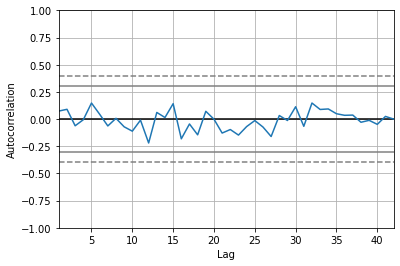

In [ ]:
autocorrelation_plot(err)
plt.show()

**26.	Рассчитайте среднее квадратичное отклонение, воспользовавшись функцией sem() из модуля scipy.stats. Запишите результат в переменную sigma и выведите его на экран.**

In [ ]:
sigma =scipy.stats.sem(y)
sigma

0.00788945595667382

**27.	Рассчитайте двусторонний t критерий Стьюдента для существующего объема выборки и 95% достоверности результата (confidence). Воспользуйтесь функцией t.ppf((1 + confidence) / 2., len(y)-1) из модуля scipy.stats. Запишите результат в переменную tstu и выведите его на экран.**

In [ ]:
confidence=0.95

In [ ]:
tstu=scipy.stats.t.ppf((1 + confidence) / 2., len(y)-1)
tstu

2.0195409639828936

**28.	Возьмите в качестве факторов на прогнозном интервале с 49 по 60 наблюдения (x_new) значения факторов тестового набора (x_test).**

In [ ]:
x_new=x_test
x_new

array([[10.12, 10.13, 10.14, 10.16, 10.16, 10.15],
       [10.13, 10.14, 10.16, 10.16, 10.15, 10.15],
       [10.14, 10.16, 10.16, 10.15, 10.15, 10.15],
       [10.16, 10.16, 10.15, 10.15, 10.15, 10.18],
       [10.16, 10.15, 10.15, 10.15, 10.18, 10.18],
       [10.15, 10.15, 10.15, 10.18, 10.18, 10.16],
       [10.15, 10.15, 10.18, 10.18, 10.16, 10.17],
       [10.15, 10.18, 10.18, 10.16, 10.17, 10.14],
       [10.18, 10.18, 10.16, 10.17, 10.14, 10.16],
       [10.18, 10.16, 10.17, 10.14, 10.16, 10.12],
       [10.16, 10.17, 10.14, 10.16, 10.12, 10.14],
       [10.17, 10.14, 10.16, 10.12, 10.14, 10.12]])

**29.	Найдите прогнозные значения цены на материал 3 на год вперед (точечный прогноз), воспользовавшись функцией predict() модели линейной регрессии. Запишите результат в переменную y_new и выведите его на экран.**

In [ ]:
y_new=model.predict(x_new)
y_new

array([10.15241992, 10.14402769, 10.15167698, 10.16652961, 10.18445485,
       10.17096415, 10.15362469, 10.16080782, 10.15300461, 10.15018149,
       10.13476688, 10.13682254])

**30.	Рассчитайте верхнюю границу прогнозного интервала, воспользовавшись формулой: y_up=y_new+tstu*sigma. Выведите результат на экран.**

In [ ]:
y_up=y_new+tstu*sigma
y_up

array([10.168353  , 10.15996077, 10.16761006, 10.18246269, 10.20038793,
       10.18689722, 10.16955777, 10.1767409 , 10.16893769, 10.16611457,
       10.15069996, 10.15275561])

**31.	Рассчитайте нижнюю границу прогнозного интервала, воспользовавшись формулой: y_down=y_new-tstu*sigma. Выведите результат на экран.**

In [ ]:
y_down=y_new-tstu*sigma
y_down

array([10.13648684, 10.12809461, 10.1357439 , 10.15059653, 10.16852177,
       10.15503107, 10.13769161, 10.14487474, 10.13707153, 10.13424841,
       10.1188338 , 10.12088946])

**32.	Сгенерируйте номера наблюдений для выборки и прогнозного интервала. Поместите их в переменные 't' и 't_new' соответственно. Они вам понадобятся при построении диаграммы.**

In [ ]:
t=np.arange(1,43)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42])

In [ ]:
t_new=np.arange(43,55)
t_new

array([43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54])

In [ ]:
t_new=t_new.reshape(-1,1)

**33.	Нанесите на одну диаграмму фактические значения, значения по модели, точечный и интервальный прогнозы, воспользовавшись функциями figure(), scatter(), plot(), xlabel(), ylabel(), legend() и show() из модуля matplotlib.pyplot.**

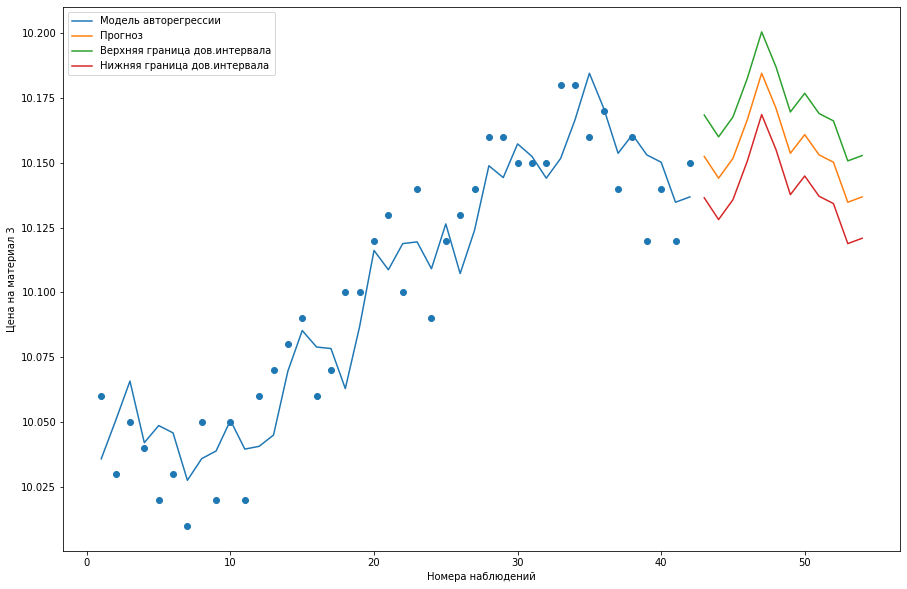

In [ ]:
plt.figure(figsize=(15,10))

plt.scatter(t,y)

plt.plot(t,y_pred)
plt.plot(t_new,y_new)
plt.plot(t_new,y_up)
plt.plot(t_new,y_down)

plt.xlabel('Номера наблюдений')
plt.ylabel('Цена на материал 3')
plt.legend(['Модель авторегрессии','Прогноз','Верхняя граница дов.интервала','Нижняя граница дов.интервала'])

plt.show()

# **7.1. Построение модели авторегрессии с помощью функции AutoReg**

**34.	Вытащите значения переменной series, обратившись к параметру values. Результат запишите в переменную X.**

In [ ]:
X=series.values

**35.	Разделите выборку на обучающую и тестовую (12 последних наблюдений). Результат запишите в переменные train и test.**

In [ ]:
train, test = X[0:len(X)-12], X[len(X)-12:]

# **СТАТИЧЕСКАЯ МОДЕЛЬ АВТОРЕГРЕССИИ**

**36.	Постройте статическую модель авторегрессии. Воспользуйтесь функцией AutoReg(data, lags=lags,old_names=False) из модуля statsmodels.tsa.ar_model, чтобы автоматизировать процесс построения авторегрессии. Результат запишите в переменную model. Используйте тот же порядок авторегрессии, что и ранее.**

In [ ]:
model=AutoReg(train, lags=6,old_names=False)

**37.	Обучите созданную модель, воспользовавшись функцией fit(). Результат запишите в переменную model_fit.**

In [ ]:
model_fit=model.fit()

**38.	Выведите на экран коэффициенты модели, обратившись к параметру модели params.**

In [ ]:
model_fit.params

array([-1.13058381,  0.24478978,  0.67201834, -0.06657351, -0.33216294,
        0.30568777,  0.28957294])

**39.	 Сделайте прогноз по модели для тестовой выборки, воспользовавшись функцией predict(start=start, end=end, dynamic=False). Результат запишите в переменную predictions.**

In [ ]:
predictions=model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
predictions

array([10.16431481, 10.1604081 , 10.17874681, 10.18877065, 10.1959967 ,
       10.20605869, 10.20956998, 10.21785539, 10.22754769, 10.23702378,
       10.24930723, 10.25927188])

**40.	Выведите на экран для каждого наблюдения из тестового набора его прогнозное (predictions) и фактическое значение (test), воспользовавшись циклом for и функцией print().**

In [ ]:
for i in range(len(predictions)):
  print('predicted=%f, expected=%f' %(predictions[i], test[i]))

predicted=10.164315, expected=10.150000
predicted=10.160408, expected=10.150000
predicted=10.178747, expected=10.180000
predicted=10.188771, expected=10.180000
predicted=10.195997, expected=10.160000
predicted=10.206059, expected=10.170000
predicted=10.209570, expected=10.140000
predicted=10.217855, expected=10.160000
predicted=10.227548, expected=10.120000
predicted=10.237024, expected=10.140000
predicted=10.249307, expected=10.120000
predicted=10.259272, expected=10.150000


**41.	Выведите на экран значение RMSE на тестовом наборе, воспользовавшись функцией sqrt() из модуля math и функцией mean_squared_error(test, predictions) из модуля sklearn.metrics.**

In [ ]:
RMSE =sqrt(mean_squared_error(test,predictions))
RMSE

0.07118975750556977

In [ ]:
R2=r2_score(test,predictions)
R2

-12.927277607119402

**42.	Нанесите на одну диаграмму фактические и прогнозные значения для тестового набора, воспользовавшись функциями plot() и show() из модуля matplotlib.pyplot. Прогноз изобразите красным цветом, указав атрибут color='red' в функции plot().**

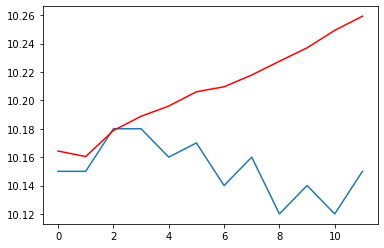

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# **ДИНАМИЧЕСКАЯ МОДЕЛЬ АВТОРЕГРЕССИИ**

**43.	 Постройте динамическую модель авторегрессии. Проведите пересчет значений по модели при условии поступления на каждом шаге нового наблюдения из тестового набора. Расчет ведите на основе найденных в ходе обучения коэффициентов модели и последних наблюдений в количестве, равном лагу. Выведите на экран для каждого наблюдения из тестового набора его прогнозное и фактическое значение. Это потребует выполнения следующего кода:**

In [ ]:
# split dataset
X = series.values
train, test = X[0:len(X)-12], X[len(X)-12:]
# train autoregression
window = 6
model = AutoReg(train, lags=6,old_names=False)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=10.164315, expected=10.150000
predicted=10.156904, expected=10.150000
predicted=10.166579, expected=10.180000
predicted=10.183036, expected=10.180000
predicted=10.200140, expected=10.160000
predicted=10.190351, expected=10.170000
predicted=10.169394, expected=10.140000
predicted=10.179272, expected=10.160000
predicted=10.178672, expected=10.120000
predicted=10.174883, expected=10.140000
predicted=10.158797, expected=10.120000
predicted=10.157086, expected=10.150000


**44.	Рассчитайте значение RMSE на тестовом наборе, воспользовавшись функцией sqrt() из модуля math и функцией mean_squared_error(test, predictions) из модуля sklearn.metrics.**

In [ ]:
RMSE =sqrt(mean_squared_error(test,predictions))
RMSE

0.0287478565959798

**45.	Нанесите на одну диаграмму фактические и прогнозные значения для тестового набора, воспользовавшись функциями plot() и show() из модуля matplotlib.pyplot. Прогноз изобразите красным цветом, указав атрибут color='red' в функции plot().**

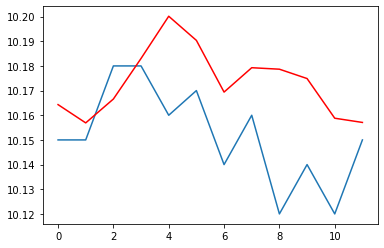

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# **ОПРЕДЕЛЯЕМ ОПТИМАЛЬНЫЙ ПО КРИТЕРИЮ BIC ПОРЯДОК АВТОРЕГРЕССИИ**

**46.	 Воспользуйтесь функцией ar_select_order(data, maxlag=max_tau) из модуля statsmodels.tsa.ar_model, чтобы определить оптимальный по критерию BIC порядок авторегрессии. Результат запишите в переменную modelp.**

In [ ]:
modelp=ar_select_order(train, maxlag=max_tau)

**47.	Выведите на экран порядок авторегрессии, обратившись к параметру ar_lags.**

In [ ]:
lags=modelp.ar_lags
lags

[1, 2]

**48. Постройте статическую и динамическую модель авторегрессии с оптимальным лагом. Прокомментируйте полученный результат.**

In [ ]:
model=AutoReg(train, lags=lags,old_names=False)

In [ ]:
model_fit=model.fit()

In [ ]:
model_fit.params

array([-0.15743569,  0.41955524,  0.59655133])

In [ ]:
predictions=model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [ ]:
for i in range(len(predictions)):
  print('predicted=%f, expected=%f' %(predictions[i], test[i]))

predicted=10.162012, expected=10.150000
predicted=10.161086, expected=10.150000
predicted=10.167863, expected=10.180000
predicted=10.170154, expected=10.180000
predicted=10.175158, expected=10.160000
predicted=10.178624, expected=10.170000
predicted=10.183063, expected=10.140000
predicted=10.186993, expected=10.160000
predicted=10.191291, expected=10.120000
predicted=10.195438, expected=10.140000
predicted=10.199742, expected=10.120000
predicted=10.204022, expected=10.150000


In [ ]:
RMSE =sqrt(mean_squared_error(test,predictions))
RMSE

0.04166487551247743

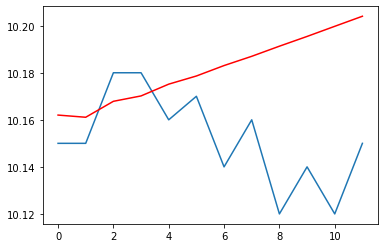

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
# split dataset
X = series.values
train, test = X[0:len(X)-12], X[len(X)-12:]
# train autoregression
window = 2
model = AutoReg(train, lags=lags,old_names=False)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=10.162012, expected=10.150000
predicted=10.156046, expected=10.150000
predicted=10.156046, expected=10.180000
predicted=10.168633, expected=10.180000
predicted=10.186529, expected=10.160000
predicted=10.178138, expected=10.170000
predicted=10.170403, expected=10.140000
predicted=10.163782, expected=10.160000
predicted=10.154276, expected=10.120000
predicted=10.149425, expected=10.140000
predicted=10.133954, expected=10.120000
predicted=10.137494, expected=10.150000


In [ ]:
RMSE =sqrt(mean_squared_error(test,predictions))
RMSE

0.018724522424567777

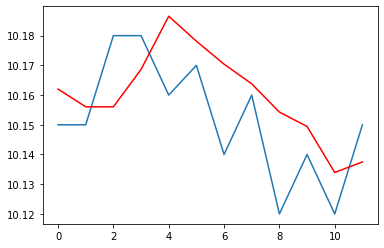

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()